
Top 10 Selected Features:
['num__totalcharges', 'num__tenure', 'num__monthlycharges', 'cat__contract_Month-to-month', 'cat__onlinesecurity_No', 'cat__paymentmethod_Electronic check', 'cat__internetservice_Fiber optic', 'cat__techsupport_No', 'num__seniorcitizen', 'cat__gender_Male']

Balancing Method: Original (No balancing)
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       826
           1       0.62      0.57      0.59       299

    accuracy                           0.79      1125
   macro avg       0.74      0.72      0.73      1125
weighted avg       0.79      0.79      0.79      1125



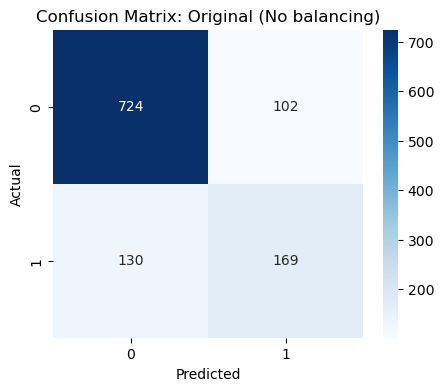

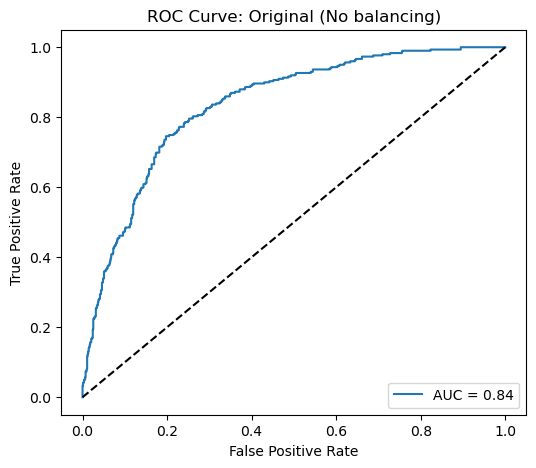


Balancing Method: Random Oversampling
              precision    recall  f1-score   support

           0       0.91      0.74      0.82       826
           1       0.53      0.80      0.63       299

    accuracy                           0.75      1125
   macro avg       0.72      0.77      0.73      1125
weighted avg       0.81      0.75      0.77      1125



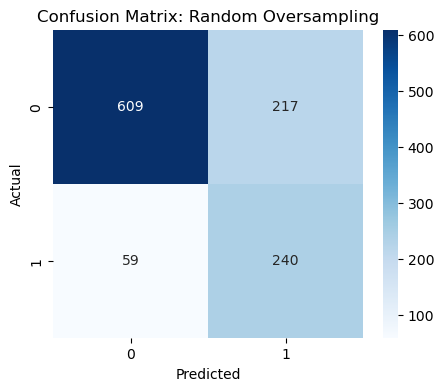

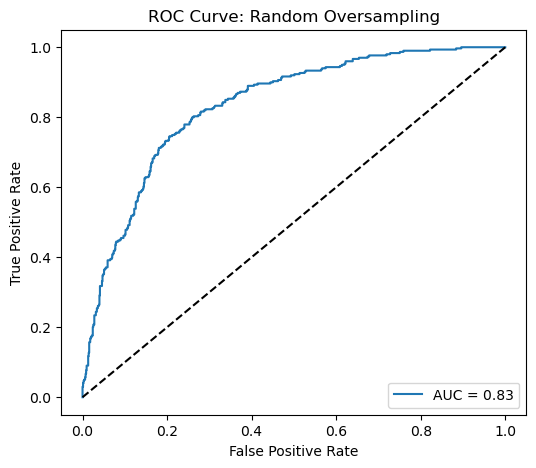


Balancing Method: Random Undersampling
              precision    recall  f1-score   support

           0       0.91      0.74      0.81       826
           1       0.52      0.79      0.63       299

    accuracy                           0.75      1125
   macro avg       0.71      0.76      0.72      1125
weighted avg       0.80      0.75      0.76      1125



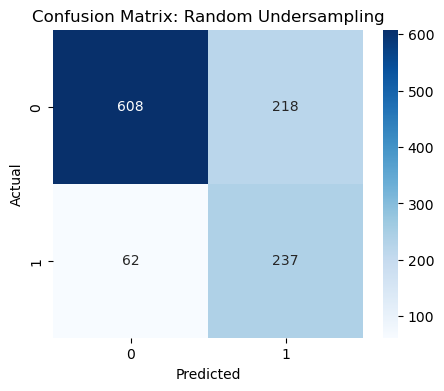

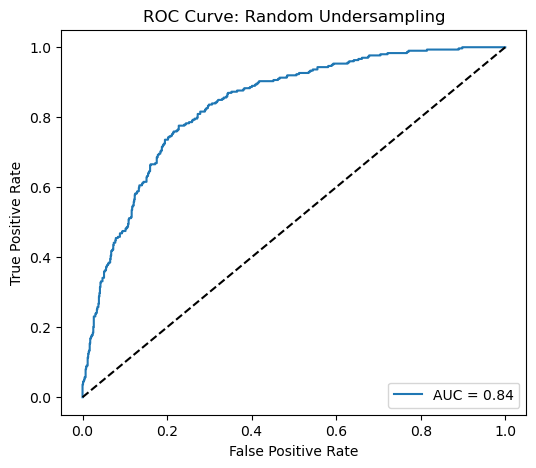


Balancing Method: SMOTE
              precision    recall  f1-score   support

           0       0.91      0.74      0.82       826
           1       0.53      0.80      0.64       299

    accuracy                           0.76      1125
   macro avg       0.72      0.77      0.73      1125
weighted avg       0.81      0.76      0.77      1125



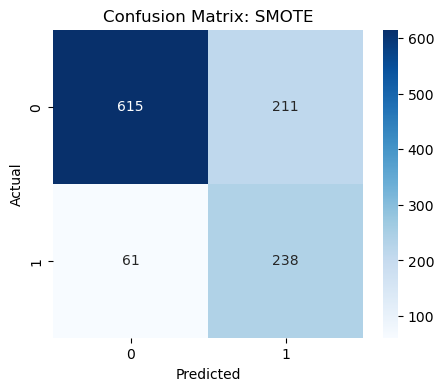

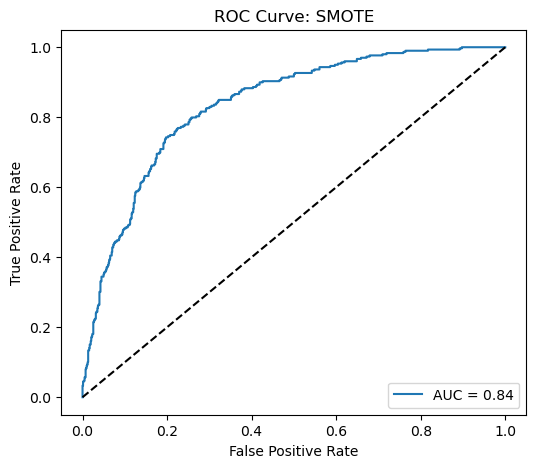


Balancing Method: ADASYN
              precision    recall  f1-score   support

           0       0.92      0.69      0.79       826
           1       0.49      0.83      0.62       299

    accuracy                           0.73      1125
   macro avg       0.70      0.76      0.70      1125
weighted avg       0.80      0.73      0.74      1125



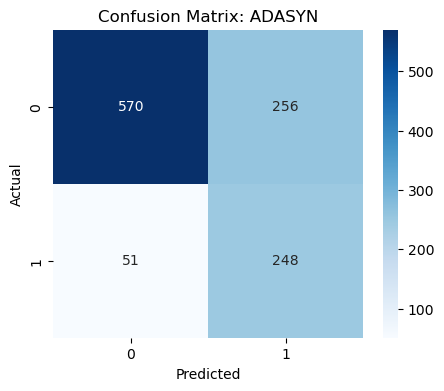

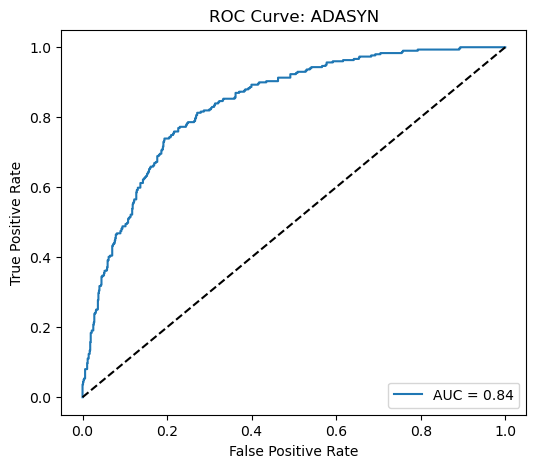


Balancing Method: SMOTE-ENN
              precision    recall  f1-score   support

           0       0.91      0.72      0.80       826
           1       0.51      0.81      0.63       299

    accuracy                           0.74      1125
   macro avg       0.71      0.76      0.71      1125
weighted avg       0.81      0.74      0.76      1125



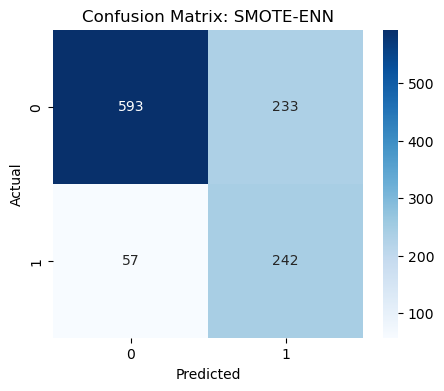

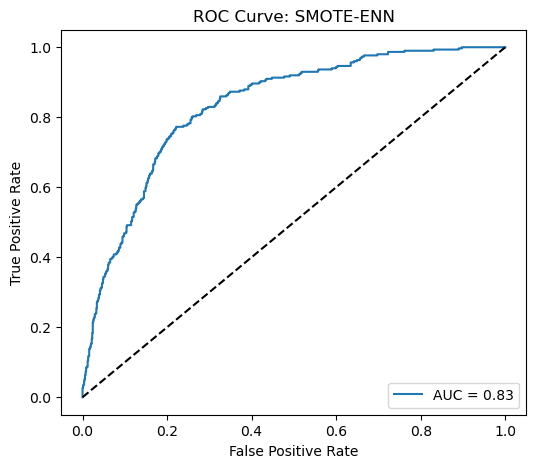


Final Model Evaluation Summary across Balancing Techniques:
                         Accuracy  Precision    Recall  F1-Score       AUC
SMOTE                    0.758222   0.530067  0.795987  0.636364  0.835410
Random Oversampling      0.754667   0.525164  0.802676  0.634921  0.833612
Random Undersampling     0.751111   0.520879  0.792642  0.628647  0.836365
SMOTE-ENN                0.742222   0.509474  0.809365  0.625323  0.833244
ADASYN                   0.727111   0.492063  0.829431  0.617684  0.837309
Original (No balancing)  0.793778   0.623616  0.565217  0.592982  0.835009


In [ ]:
# Task 4 Continued: Logistic Regression with Different Balancing Techniques on Top 10 Features

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Load dataset
train = pd.read_csv("data/train.csv")

# Separate features and target
X = train.drop(columns="churn")
y = train["churn"].map({"No": 0, "Yes": 1})

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# Preprocess the features
X_preprocessed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=feature_names)


from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_preprocessed, y)

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

top_10_features = feature_importance_df.head(10)['feature'].tolist()
print("\nTop 10 Selected Features:")
print(top_10_features)

# Filter the dataset to top 10 features
X_selected = X_preprocessed_df[top_10_features]

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing done
X_train_processed = X_train.copy()
X_val_processed = X_val.copy()

# Define imbalance handling techniques
from collections import OrderedDict
techniques = OrderedDict({
    "Original (No balancing)": (X_train_processed, y_train),
    "Random Oversampling": RandomOverSampler(random_state=42).fit_resample(X_train_processed, y_train),
    "Random Undersampling": RandomUnderSampler(random_state=42).fit_resample(X_train_processed, y_train),
    "SMOTE": SMOTE(random_state=42).fit_resample(X_train_processed, y_train),
    "ADASYN": ADASYN(random_state=42).fit_resample(X_train_processed, y_train),
    "SMOTE-ENN": SMOTEENN(random_state=42).fit_resample(X_train_processed, y_train)
})

# Evaluation function
def evaluate_balancing(model, X_train, y_train, X_test, y_test, method_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    print("\n" + "="*50)
    print(f"Balancing Method: {method_name}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {method_name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {method_name}')
    plt.legend(loc='lower right')
    plt.show()

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC": roc_auc
    }

# Train Logistic Regression on each balanced dataset
final_results = {}

for method_name, (X_resampled, y_resampled) in techniques.items():
    logreg = LogisticRegression(max_iter=1000, random_state=42)
    results = evaluate_balancing(logreg, X_resampled, y_resampled, X_val_processed, y_val, method_name)
    final_results[method_name] = results

# Summary Table
summary_df = pd.DataFrame(final_results).T
print("\nFinal Model Evaluation Summary across Balancing Techniques:")
print(summary_df.sort_values(by="F1-Score", ascending=False))


📦 Logistic Regression with Different Balancing Techniques (Step-by-Step Explanation)

1. Loaded the training dataset and separated features (X) and target (y).
2. Encoded the "churn" column into 0 (No) and 1 (Yes) to make it numeric.
3. Identified which features are numeric and which are categorical.

4. Built separate preprocessing pipelines:
   - For numeric features: handled missing values and scaled them.
   - For categorical features: handled missing values and applied one-hot encoding.

5. Applied full preprocessing and converted the dataset into a clean format.

6. Used Random Forest to find feature importance and selected the Top 10 most important features.
7. Filtered the dataset to keep only these top 10 important features.

8. Split the data into training and validation sets (80% train, 20% validation) with stratification.

9. Defined different balancing techniques to handle class imbalance:
   - Original (no balancing)
   - Random Oversampling
   - Random Undersampling
   - SMOTE
   - ADASYN
   - SMOTE-ENN

10. Built a model evaluation function that:
    - Trains Logistic Regression on each balanced dataset.
    - Prints the classification report.
    - Shows Confusion Matrix and ROC Curve for each technique.
    - Calculates Accuracy, Precision, Recall, F1-Score, and AUC.

11. Trained and evaluated Logistic Regression separately on each balanced dataset.

12. Stored the evaluation results for all balancing methods.

13. Created a final summary table showing the performance of Logistic Regression under each balancing technique, sorted by F1-Score.

✅ This process helped find which balancing technique gives the best results when combined with Logistic Regression.
